# Learning Functional Level Design: State Preparation

Let's take together the first step in using the Classiq Platform and understand its advantages :)

We start with argubaly the most fundamental bulding block in quantum algorithms design: state preparation! We use this example to express how algorithm design is (very simply) done using the Classiq Platform.

The state that we want to generate is the following probability distribution over 8 possible states:

In [ ]:
probabilities = [0.4, 0.05, 0.2, 0.05, 0.3, 0, 0, 0]

Because the probability vector is over 8 possible states, we know that in the register that stores the values contains 3 qubits ($2^3=8$).

## The Final Circuit

Let's start with what is the final circuit we will get, and then we will go through the process of building it. At the higher level, which is the level we will design it, the circuit will be:

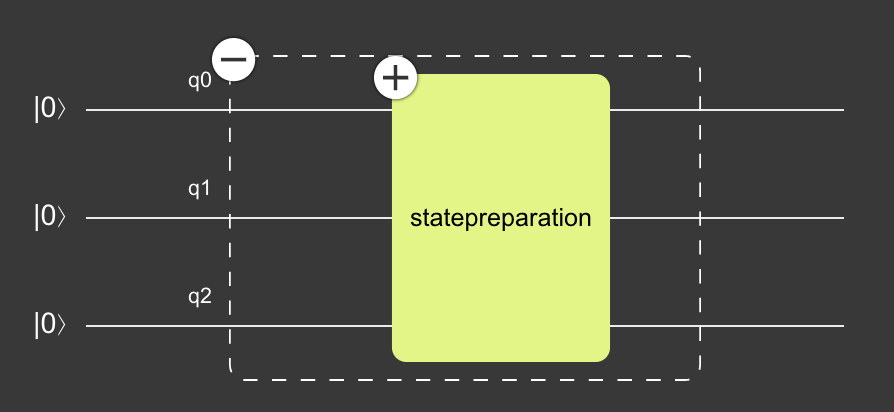

This block is implemented by some underlying gates the Classiq Platform will automatically synthesize according to the functionality we define.

 The underlying circuit is:

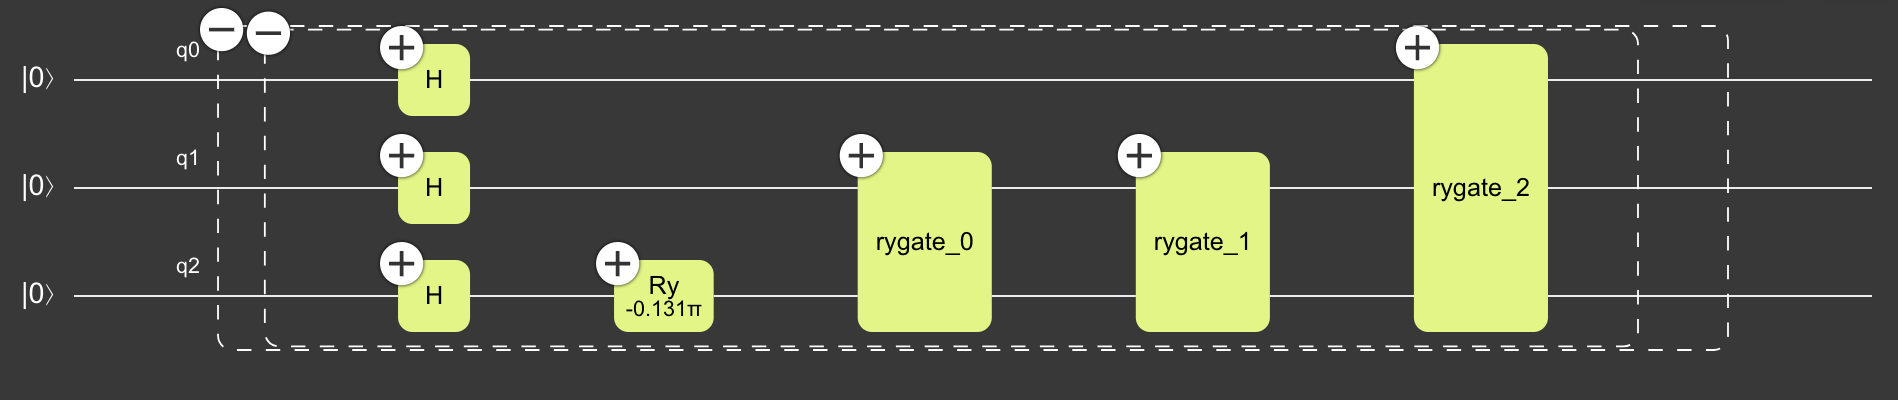

## How We Build This?

With the Classiq Platform, we build functional **models** of the quantum algorithm and then we let the platform to **synthesizing** the optimized circuit for the given models.

For any algorithm, be it the simplest or the most complex one, the model is built according to four simple steps:

1. Defining the functional blocks - in our example we have only 1 functional block, the state preperation

2. Defining an high-level functional model that will contain the functional blocks

3. Wiring the blocks within the high-level functional model

4. Defining how to execute the resulting quantum circuit

First, make sure you have the right classiq version:

## 1. Defining The Quantum Functional Block

The quantum functional block we have is the state preperation. We will define a `StatePreparation` object that encapsulates the functionality we want. This object recieves the desired probability distribution and an upper bound for an error of the implementation (since usually there is a trade-off between accuracy of the implementation and the number of qubits and/or depth of the circuit).

The final circuit implements the desired probability distribution with an error which is bounded by the upper bound given.

In [ ]:
from classiq.builtin_functions import StatePreparation

sp = StatePreparation(
    probabilities=probabilities, error_metric={"KL": {"upper_bound": 0.1}}
)

Above we defined the error metric to be according to the Kullback-Leibler (KL) divergence metric, with the upper bound being 0.3.

## 2. Defining the High-Level Functional Model

The high-level functional model encapsulates the functionality of our algorithm, and specifically `StatePreparation` block we have defined. The model is stored within an instance of the `Model` object:

In [ ]:
from classiq import Model

model = Model()

## 3. Wiring the Blocks within the High-Level Functional Model

Now that we can wire the state preparation object `sp` into our `model` object:

In [ ]:
model.StatePreparation(params=sp)

## 4. Defining how to execute the resulting quantum circuit

In this tutorial we simply want to take samples on all the qubits from the resulting circuit.

In [ ]:
model.sample()

 We can also declare in the model on which backend we would like to execute our circuit.

In [ ]:
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences

backend_preferences = ClassiqBackendPreferences(
    backend_name="aer_simulator_statevector"
)

serialized_model = model.get_model()

serialized_model = set_execution_preferences(
    serialized_model,
    execution_preferences=ExecutionPreferences(
        num_shots=1000, backend_preferences=backend_preferences
    ),
)

## Synthesizing The Circuit

Now that we have our model completed we can synthesize a quantum program that implemnt it. There are many options for circuits that implemnt the same quantum functionality, and they will vary in their depth and width (#qubits).

Let's start by just asking the Classiq Platform to synthesize a quantum program

In [ ]:
from classiq import synthesize

qprog = synthesize(serialized_model)

and then to show the corresponding quantum circuit:

In [ ]:
from classiq import show

show(qprog)

we will get the circuit:

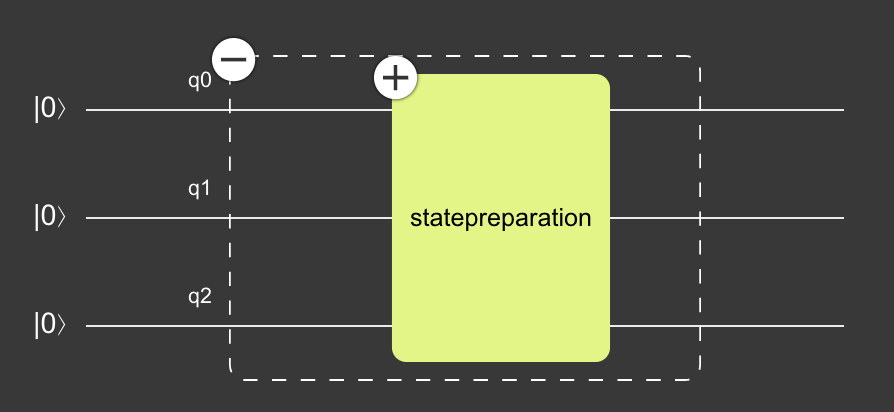

If we zoom in, we can see the gate-level implementation:

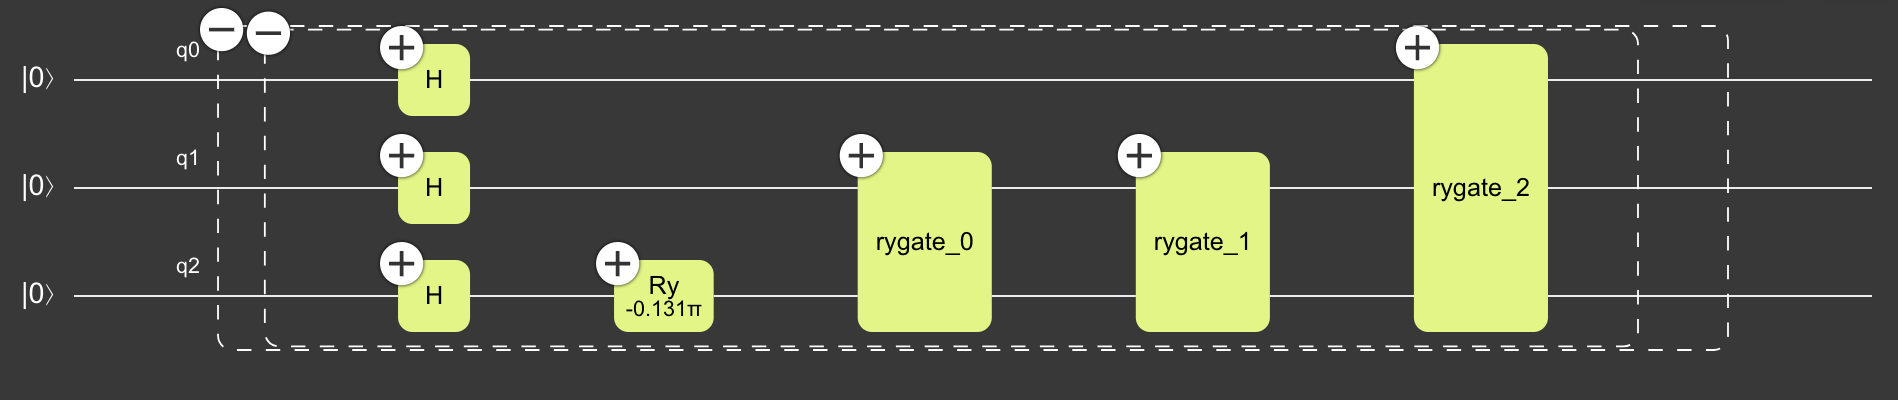

In [ ]:
from classiq import GeneratedCircuit

circuit = GeneratedCircuit.from_qprog(qprog)

circuit.save_results("my_state_preperation_circuit.json")

## Execution

Now we can execute our quantum program to get the measurement results, specified in our quatum model.

In [ ]:
from classiq import execute

results_raw = execute(qprog).result()

We are interested in the `counts` field:

In [ ]:
from classiq.execution import ExecutionDetails

results = results_raw[0].value
print(results.parsed_counts)

And then we can make the transition to a desired probability vector:

In [ ]:
resulted_prob = [0] * len(probabilities)

for sampled_state in results.parsed_counts:
    resulted_prob[int(sampled_state.state["meas"])] = sampled_state.shots / 1000

print("Resulted probability", resulted_prob)
print("Desired probability", probabilities)

Which is indeed pretty close!
If one wishes to make it closer, they can define it in the error metric of the `StatePreparation` object.

### Executing our circuit on the platform's web application

We can also execute our circuit through the web application.
Once we have a circuit loaded to the web application (for example by using the `show` function we used above), the execution icon will appear on the sidebar on the left. We can click this icon to go to the execution page. This page contains two sections: Quantum Devices and Execution Management. Let's execute our state preparation circuit on the Azur Quantum `Ionq.Simulator` with 1000 shots:

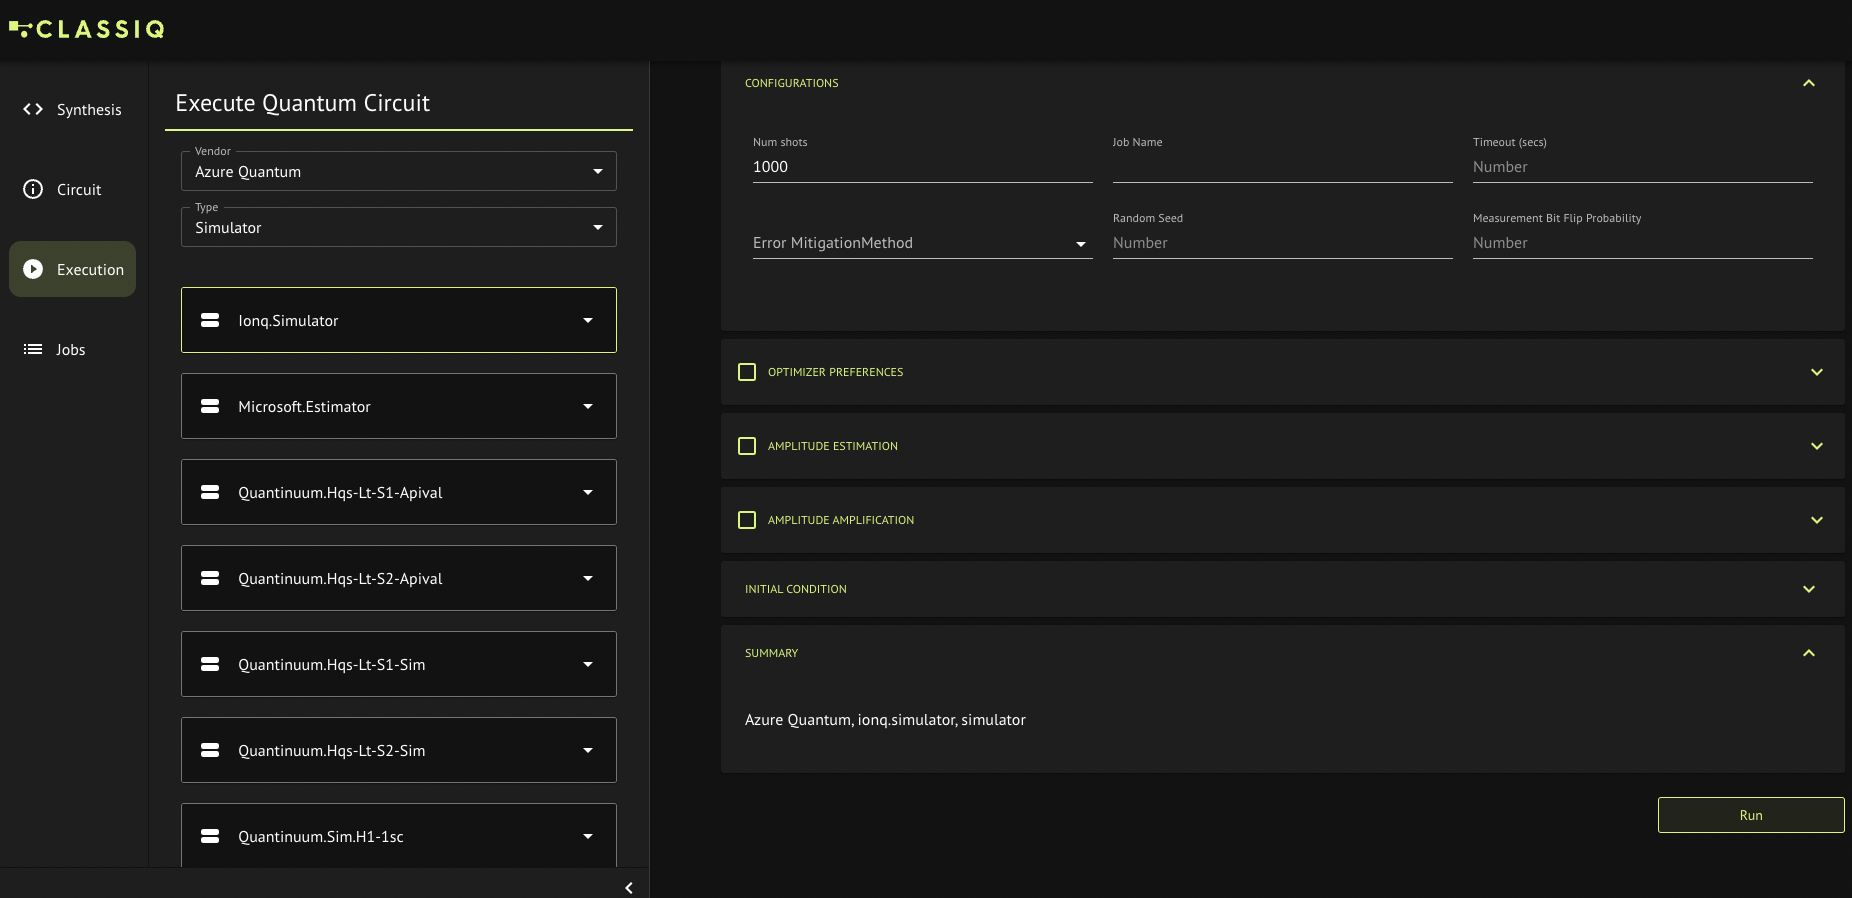

Once we have our executions preferences are ready we can push the `Run` button on the bottom right corner.
A progress bar will be presented:

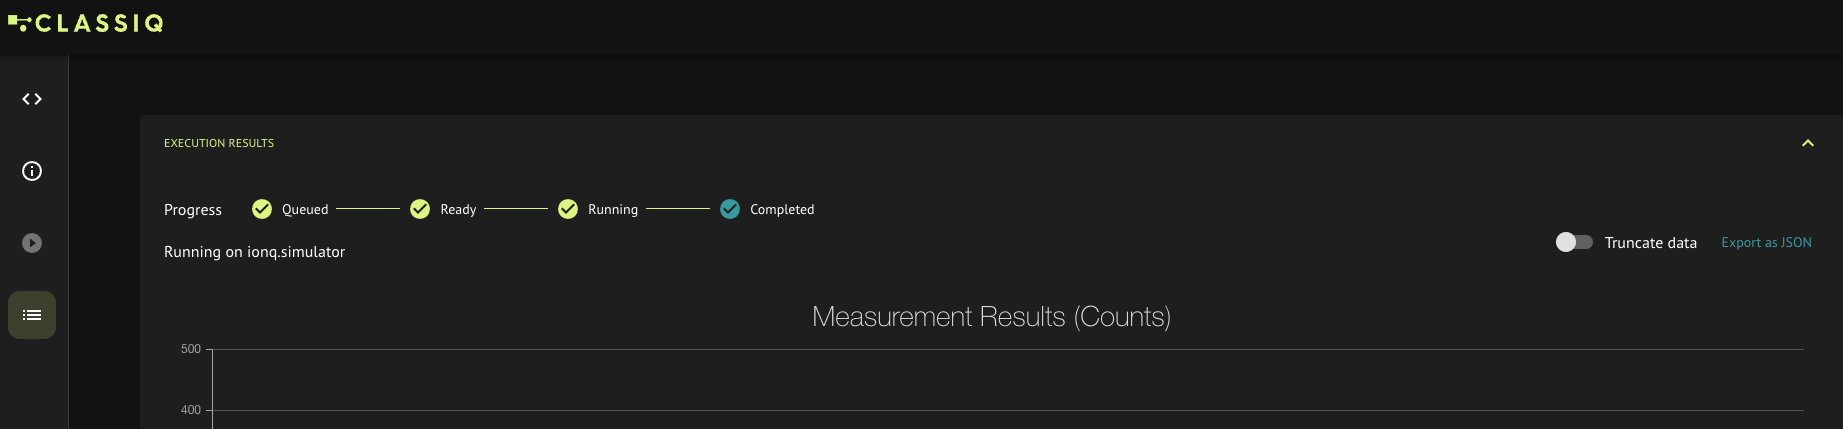

When our execution is completed we will be presented with the results:

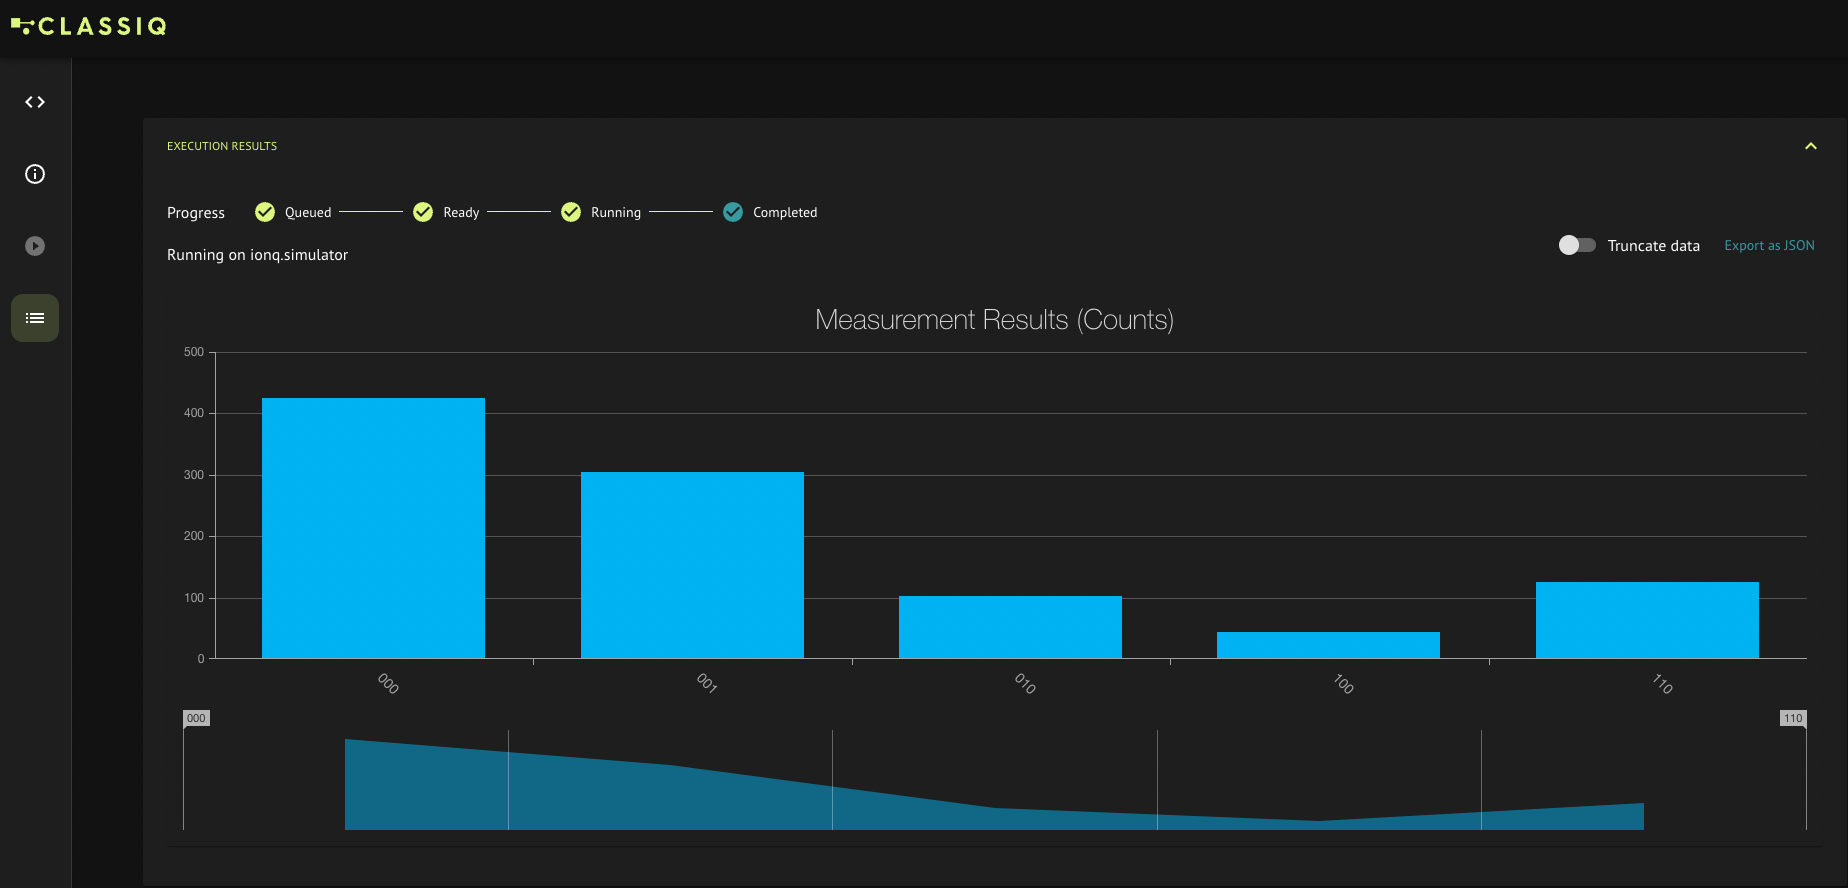

Should we want to download our results for post processing, we can download our results through the `Export as JSON` button.

## All Code Together

In [ ]:
# This code was written for classiq 0.21

from classiq import Model, execute, show, synthesize
from classiq.builtin_functions import StatePreparation
from classiq.execution import (
    ClassiqBackendPreferences,
    ExecutionDetails,
    ExecutionPreferences,
)
from classiq.synthesis import set_execution_preferences

# defining probabilities
probabilities = [0.4, 0.05, 0.2, 0.05, 0.3, 0, 0, 0]

# defining state preparation object
sp = StatePreparation(
    probabilities=probabilities, error_metric={"KL": {"upper_bound": 0.3}}
)

# defining the model
model = Model()

# wiring
model.StatePreparation(params=sp)

# defining how to execute
model.sample()

serialized_model = model.get_model()

backend_preferences = ClassiqBackendPreferences(
    backend_name="aer_simulator_statevector"
)

serialized_model = set_execution_preferences(
    serialized_model,
    execution_preferences=ExecutionPreferences(
        num_shots=1000, backend_preferences=backend_preferences
    ),
)

# synthesizing
qprog = synthesize(serialized_model)

# showing circuit
show(qprog)

# execution
results_raw = execute(qprog).result()
results = results_raw[0].value
print(results.parsed_counts)

# understanding the results
resulted_prob = [0] * len(probabilities)
for sampled_state in results.parsed_counts:
    resulted_prob[int(sampled_state.state["meas"])] = sampled_state.shots / 1000

print("Resulted probability", resulted_prob)
print("Desired probability", probabilities)